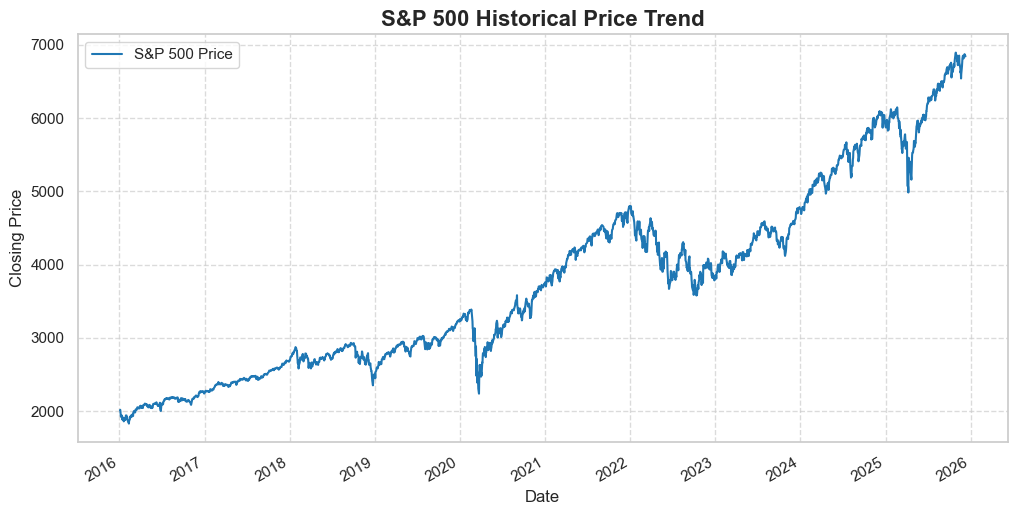

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sp500_from_csv(file_path):
    try:
        # 1. 读取 CSV 文件
        # 假设文件名为 'sp500.csv'，且与脚本在同一目录下
        df = pd.read_csv(file_path)
        
        # 2. 数据清洗
        # 将 'Date' 列转换为 datetime 对象，以便 matplotlib 正确处理时间轴
        df['Date'] = pd.to_datetime(df['Date'])
        
        # 处理 'Price' 列：去除千位分隔符逗号，并转换为浮点数
        # 如果您的数据中 'Price' 列已经是数字格式，这行代码也不会报错，但为了保险起见建议加上
        if df['Price'].dtype == 'object':
            df['Price'] = df['Price'].str.replace(',', '').astype(float)
            
        # 3. 排序
        # 原始数据通常是倒序排列（最新日期在最前），绘图前需要按日期升序排列
        df = df.sort_values('Date')
        
        # 4. 绘图
        plt.figure(figsize=(12, 6)) # 设置画布大小
        plt.plot(df['Date'], df['Price'], label='S&P 500 Price', color='#1f77b4', linewidth=1.5)
        
        # 5. 图表美化
        plt.title('S&P 500 Historical Price Trend', fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Closing Price', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7) # 添加网格线
        plt.legend() # 显示图例
        
        # 优化日期显示格式（自动旋转日期标签以免重叠）
        plt.gcf().autofmt_xdate()
        
        # 显示图表
        plt.show()
        
    except FileNotFoundError:
        print(f"错误：找不到文件 '{file_path}'。请确保文件在当前目录下或路径正确。")
    except Exception as e:
        print(f"发生错误：{e}")

# --- 执行绘图 ---
# 请确保您的文件名是 'sp500.csv'
plot_sp500_from_csv('sp500.csv')

--- 开始复现论文第7章：主成分组合构建 ---


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/723289432.py:32: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Ret'] = df.groupby('PERMNO')[price_col].pct_change()


开始滚动计算 (窗口=504, 步长=20)...


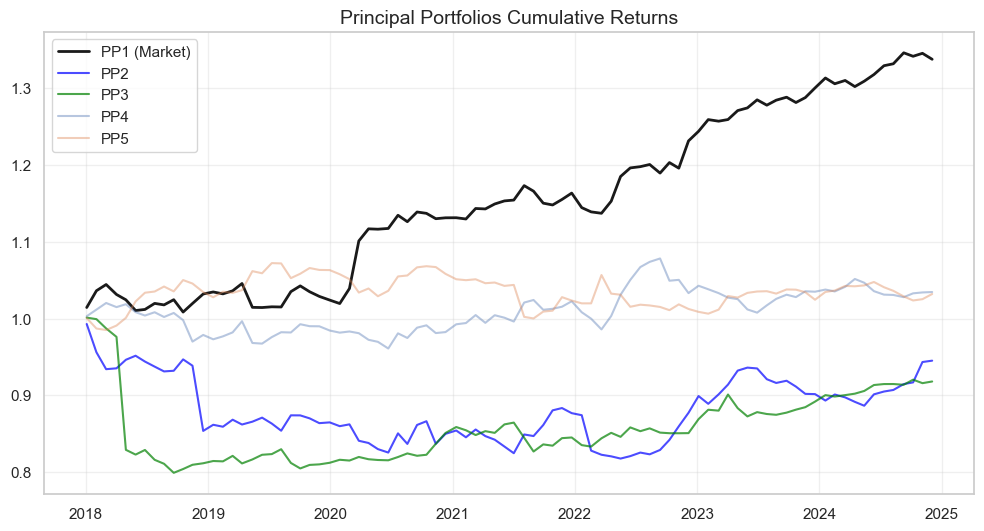

PP1 通常对应大盘指数。观察 PP2 和 PP3 是否有超越大盘的表现（Alpha）。


In [6]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def replicate_chapter_7_principal_portfolios(file_path):
    print("--- 开始复现论文第7章：主成分组合构建 ---")
    
    # 1. 读取与清洗数据 (同前)
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except FileNotFoundError:
        print("找不到文件，请检查文件名。")
        return

    # 识别列名
    date_col = next((c for c in ['DlyCalDt', 'date', 'Date'] if c in df.columns), None)
    price_col = next((c for c in ['DlyClose', 'Prc', 'Close', 'Est_Close'] if c in df.columns), None)
    
    # 如果没有收盘价，构造一个
    if not price_col and 'DlyHigh' in df.columns:
        df['Est_Close'] = (df['DlyHigh'] + df['DlyLow']) / 2
        price_col = 'Est_Close'
        
    if not date_col or not price_col:
        print("缺少日期或价格列，无法继续。")
        return

    # 准备收益率矩阵
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.sort_values([date_col, 'PERMNO'])
    df['Ret'] = df.groupby('PERMNO')[price_col].pct_change()
    
    # 筛选时间 (论文使用的时间段不同，这里用您的数据时间 2016-2024)
    mask = (df[date_col] >= '2016-01-01') & (df[date_col] <= '2024-12-31')
    returns_matrix = df.loc[mask].pivot(index=date_col, columns='PERMNO', values='Ret')

    # 2. 第7章核心参数
    window_size = 504  # 2年滚动窗口
    n_pps = 10         # 构建前10个主成分组合
    rf_rate = 0.02 / 252 # 假设无风险利率 (用于空头资金收益)
    
    pp_returns = {i: [] for i in range(1, n_pps + 1)}
    dates = []
    
    # 3. 滚动构建组合
    # 为了演示速度，step设为20 (月度调整)。若要严格复现论文，请设 step=1
    step = 20 
    trading_days = returns_matrix.index
    
    print(f"开始滚动计算 (窗口={window_size}, 步长={step})...")
    
    for t in range(window_size, len(trading_days) - 1, step):
        # 获取窗口内数据
        window_data = returns_matrix.iloc[t-window_size : t]
        
        # 筛选有效股票 (必须在窗口内数据完整)
        # 论文方法：只选全时段有数据的股票。
        # 改进方法(更适合滚动)：只选当前窗口内数据覆盖率高的股票。
        valid_stocks = window_data.columns[window_data.count() > 0.9 * window_size]
        if len(valid_stocks) < 50: continue
            
        # 填充缺失值并标准化
        X = window_data[valid_stocks].fillna(0)
        
        # PCA 分解
        pca = PCA(n_components=n_pps)
        pca.fit(X)
        
        # 获取次日个股收益 (用于计算组合表现)
        next_ret = returns_matrix[valid_stocks].iloc[t].fillna(0)
        dates.append(trading_days[t])
        
        # --- 第7章核心：权重分配逻辑 ---
        for i in range(n_pps):
            # 获取第 i 个主成分的特征向量 (Eigenvector)
            w = pca.components_[i]
            
            # PP1 方向调整：确保代表市场方向 (多数为正)
            if i == 0 and np.sum(w) < 0:
                w = -w
            
            # 分离多空仓位
            long_pos = w > 0
            short_pos = w < 0
            
            # 权重归一化 (Normalize)
            # 论文逻辑：多头总权重=1，空头总权重=-1
            sum_long = np.sum(w[long_pos])
            sum_short = np.sum(np.abs(w[short_pos]))
            
            final_w = np.zeros_like(w)
            
            if sum_long > 0:
                final_w[long_pos] = w[long_pos] / sum_long
            
            if sum_short > 0:
                final_w[short_pos] = w[short_pos] / sum_short
            
            # 计算组合收益
            # R_p = sum(w * r)
            port_ret = np.sum(final_w * next_ret)
            
            # 空头资金利息：如果我们卖空了股票，这部分现金产生无风险收益
            if sum_short > 0:
                port_ret += rf_rate
            
            pp_returns[i + 1].append(port_ret)

    # 4. 绘图结果
    res_df = pd.DataFrame(pp_returns, index=dates)
    cum_res = (1 + res_df).cumprod()
    
    plt.figure(figsize=(12, 6))
    plt.plot(cum_res.index, cum_res[1], label='PP1 (Market)', color='k', linewidth=2)
    plt.plot(cum_res.index, cum_res[2], label='PP2', color='blue', alpha=0.7)
    plt.plot(cum_res.index, cum_res[3], label='PP3', color='green', alpha=0.7)
    
    # 绘制其他低阶成分
    for c in range(4, 6):
        plt.plot(cum_res.index, cum_res[c], label=f'PP{c}', alpha=0.4)
        
    plt.title('Principal Portfolios Cumulative Returns', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("PP1 通常对应大盘指数。观察 PP2 和 PP3 是否有超越大盘的表现（Alpha）。")

# 运行代码
replicate_chapter_7_principal_portfolios('constituents.csv')

--- 开始复现论文分析 (含相对表现) ---


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/3779357007.py:44: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Ret'] = df.groupby('PERMNO')[price_col].pct_change()


正在计算滚动 PCA 策略...


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/3779357007.py:156: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


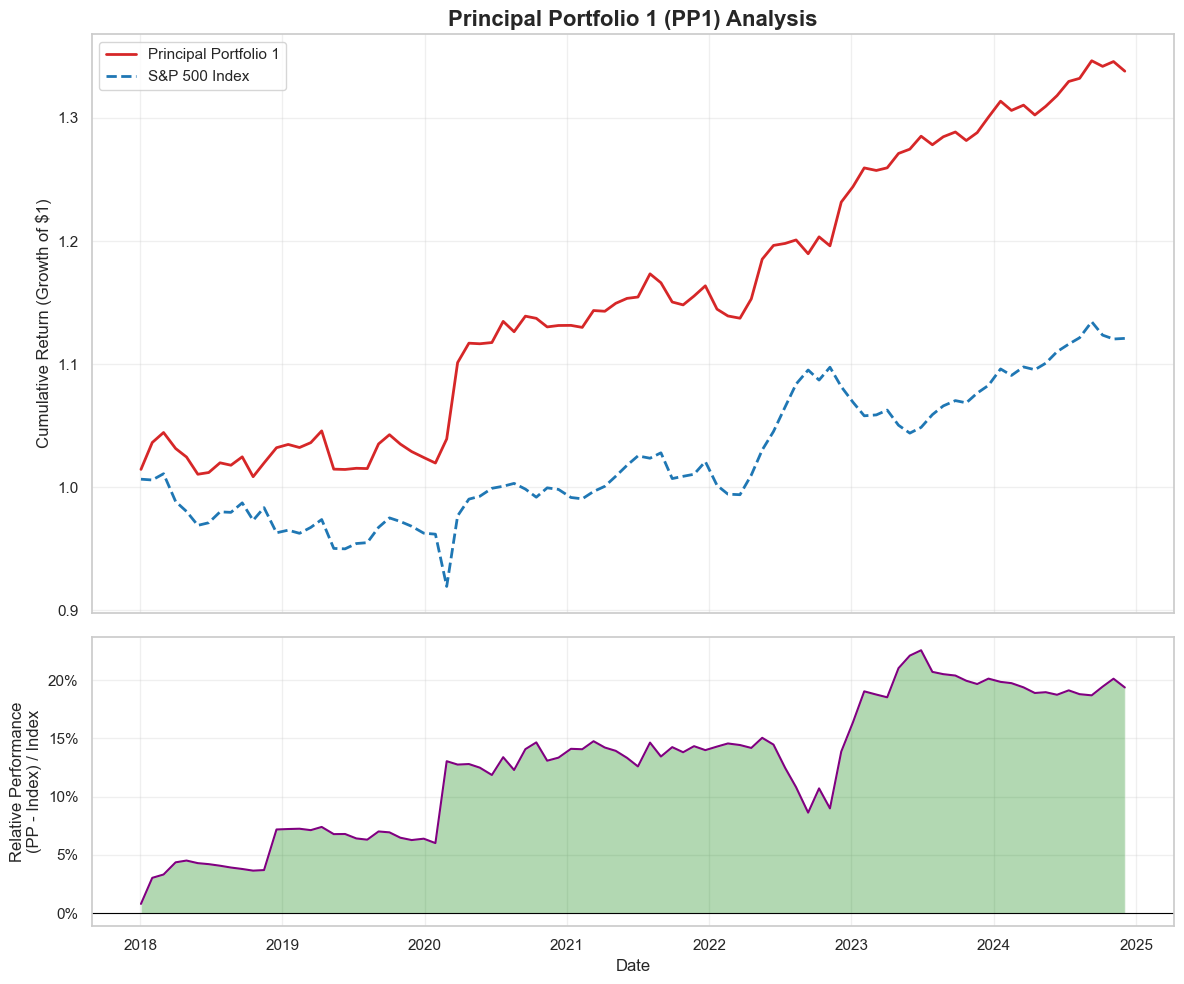

已生成图表: PP1_Analysis_and_Relative_Performance.png


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/3779357007.py:156: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


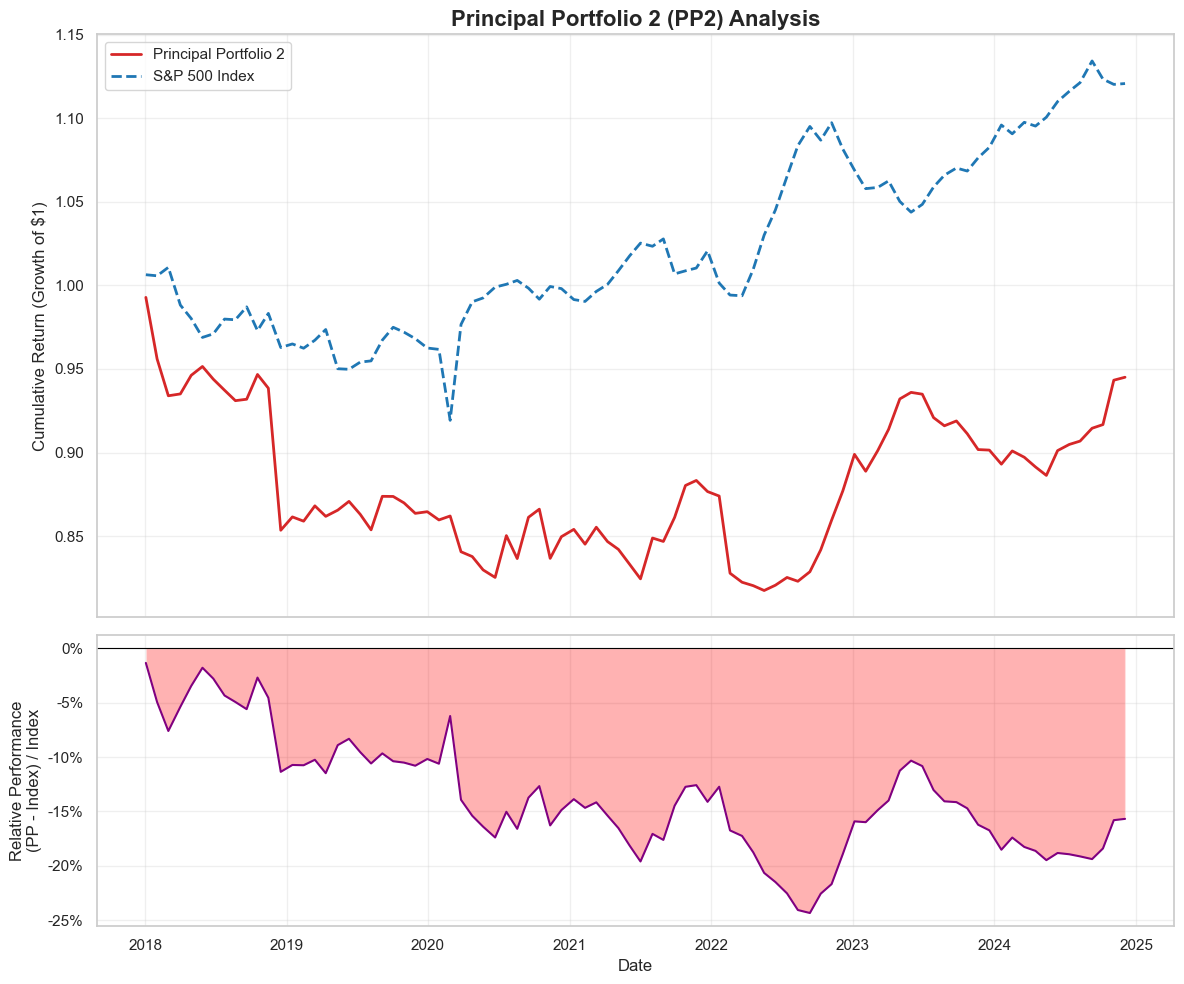

已生成图表: PP2_Analysis_and_Relative_Performance.png


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/3779357007.py:156: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


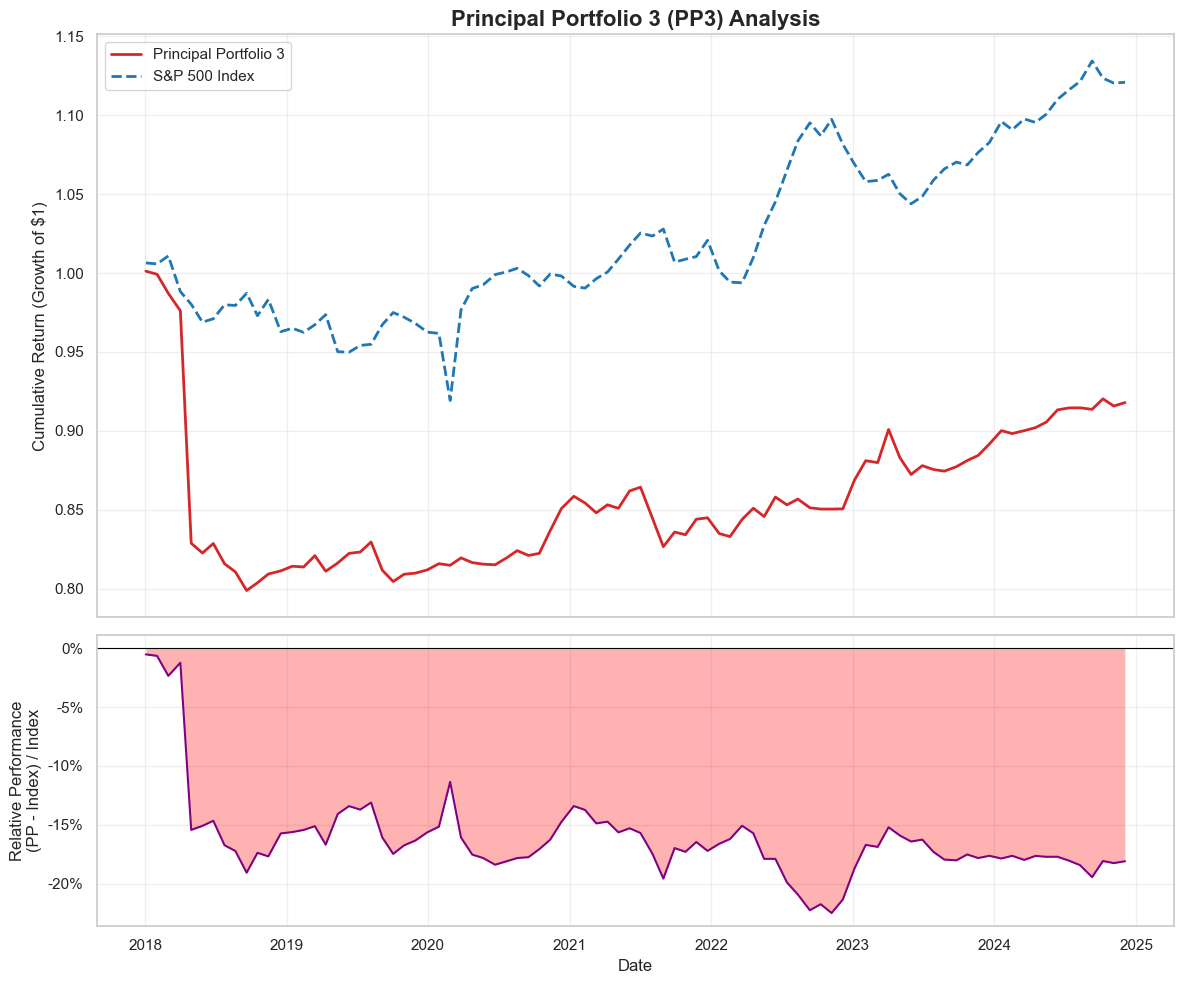

已生成图表: PP3_Analysis_and_Relative_Performance.png


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/3779357007.py:156: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


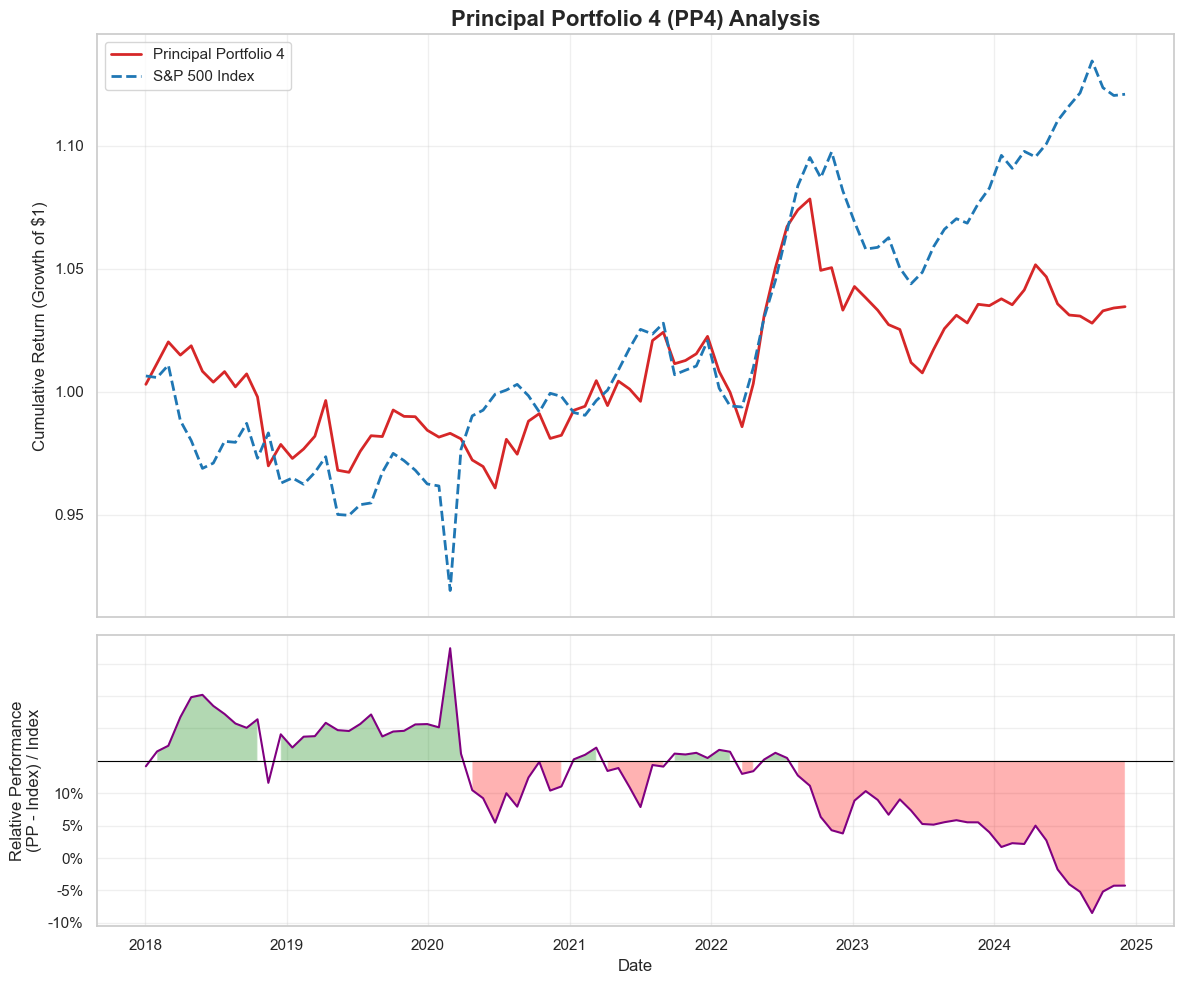

已生成图表: PP4_Analysis_and_Relative_Performance.png


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/3779357007.py:156: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


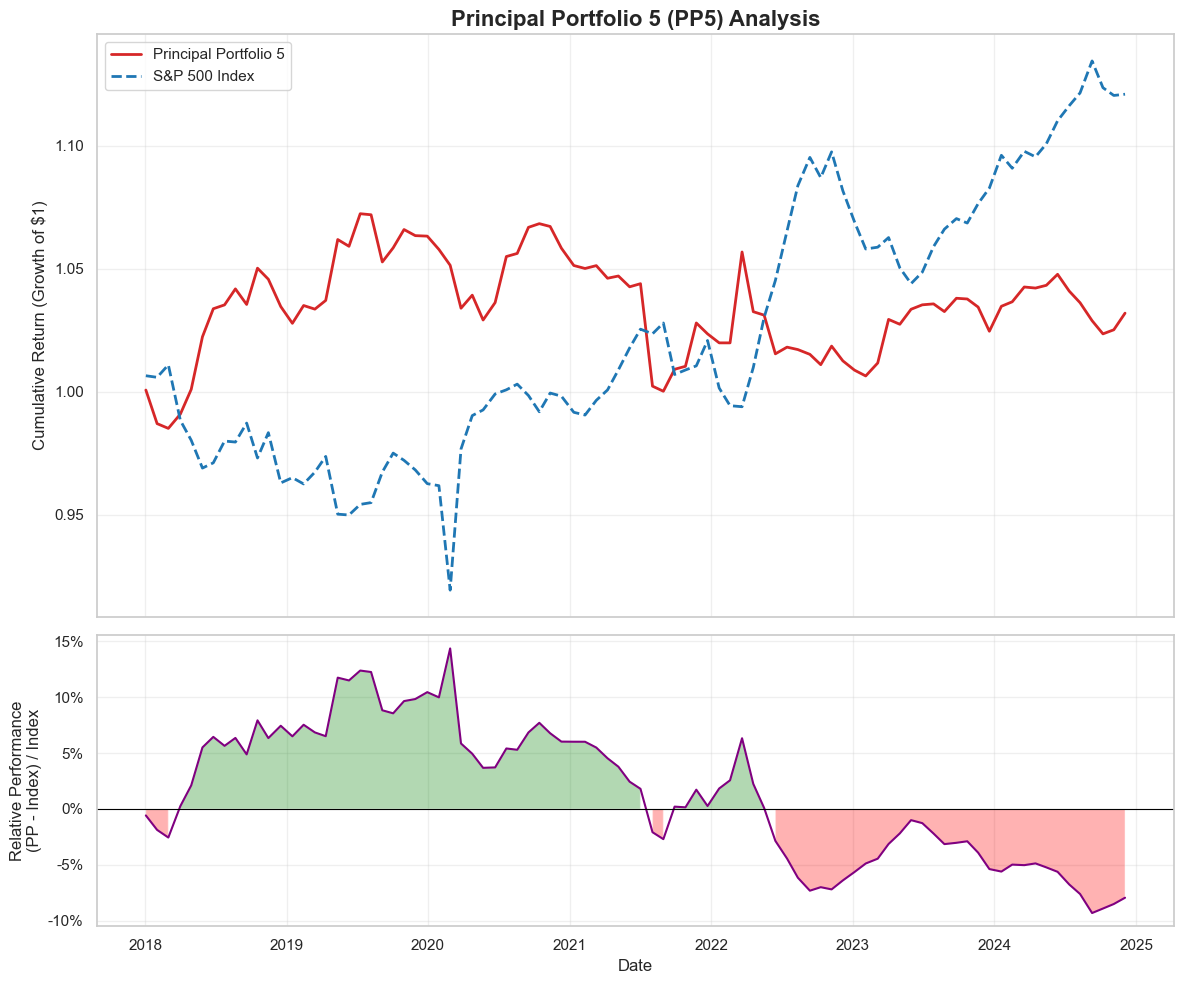

已生成图表: PP5_Analysis_and_Relative_Performance.png


In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

def plot_pp_and_relative_performance(stock_file, index_file):
    print(f"--- 开始复现论文分析 (含相对表现) ---")
    
    # ==========================================
    # 1. 数据读取与清洗
    # ==========================================
    # 读取指数数据
    try:
        sp500 = pd.read_csv(index_file)
        if sp500['Price'].dtype == 'object':
            sp500['Price'] = sp500['Price'].str.replace(',', '').astype(float)
        sp500['Date'] = pd.to_datetime(sp500['Date'])
        sp500 = sp500.sort_values('Date').set_index('Date')
        sp500_ret = sp500['Price'].pct_change()
    except Exception as e:
        print(f"读取指数文件失败: {e}")
        return

    # 读取成分股数据
    try:
        df = pd.read_csv(stock_file, low_memory=False)
        
        # 识别列名
        date_col = next((c for c in ['DlyCalDt', 'date', 'Date'] if c in df.columns), None)
        price_col = next((c for c in ['DlyClose', 'Prc', 'Close', 'Est_Close'] if c in df.columns), None)
        if not price_col and 'DlyHigh' in df.columns:
            df['Est_Close'] = (df['DlyHigh'] + df['DlyLow']) / 2
            price_col = 'Est_Close'
            
        # 计算收益率矩阵
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.sort_values([date_col, 'PERMNO'])
        df['Ret'] = df.groupby('PERMNO')[price_col].pct_change()
        
        # 筛选时间 (2016-2024)
        mask = (df[date_col] >= '2016-01-01') & (df[date_col] <= '2024-12-31')
        returns_matrix = df.loc[mask].pivot(index=date_col, columns='PERMNO', values='Ret')
        
    except Exception as e:
        print(f"读取成分股文件失败: {e}")
        return

    # ==========================================
    # 2. 滚动构建 PPs
    # ==========================================
    window_size = 504
    n_pps = 5 
    rf_rate = 0.02 / 252
    
    # 对齐数据
    common_idx = returns_matrix.index.intersection(sp500_ret.index)
    returns_matrix = returns_matrix.loc[common_idx]
    sp500_ret = sp500_ret.loc[common_idx]
    
    pp_returns = {i: [] for i in range(1, n_pps + 1)}
    dates = []
    
    step = 20 # 步长
    
    print("正在计算滚动 PCA 策略...")
    
    for t in range(window_size, len(common_idx) - 1, step):
        # 窗口数据
        window_data = returns_matrix.iloc[t-window_size : t]
        
        # 筛选有效股票
        valid = window_data.columns[window_data.count() > 0.9 * window_size]
        if len(valid) < 50: continue
            
        X = window_data[valid].fillna(0)
        
        # PCA
        pca = PCA(n_components=n_pps)
        pca.fit(X)
        
        next_ret = returns_matrix[valid].iloc[t].fillna(0)
        dates.append(common_idx[t])
        
        for i in range(n_pps):
            w = pca.components_[i]
            
            # PP1 方向校正
            if i == 0 and np.sum(w) < 0: w = -w
            
            # 权重标准化
            pos, neg = w > 0, w < 0
            sum_p, sum_n = np.sum(w[pos]), np.sum(np.abs(w[neg]))
            
            fw = np.zeros_like(w)
            if sum_p > 0: fw[pos] = w[pos] / sum_p
            if sum_n > 0: fw[neg] = w[neg] / sum_n # short weight is negative in calculation
            
            # 计算收益
            # 注意：空头权重在计算中为负数，所以直接相乘相加即可。
            # 空头部分产生现金流收益
            r = np.sum(fw * next_ret)
            if sum_n > 0: r += rf_rate
            
            pp_returns[i + 1].append(r)

    # ==========================================
    # 3. 计算累计净值与相对表现
    # ==========================================
    res_df = pd.DataFrame(pp_returns, index=dates)
    
    # 对齐指数收益
    idx_ret_aligned = sp500_ret.loc[res_df.index]
    
    # 累计净值 (Cumulative Wealth)
    cum_pp = (1 + res_df).cumprod()
    cum_idx = (1 + idx_ret_aligned).cumprod()
    
    # 相对表现 (Relative Performance)
    # 公式: (PP - Index) / Index
    rel_perf = (cum_pp.subtract(cum_idx, axis=0)).div(cum_idx, axis=0)
    
    # ==========================================
    # 4. 绘图 (双面板)
    # ==========================================
    for i in range(1, n_pps + 1):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
        
        # --- 上图: 累计净值 ---
        ax1.plot(cum_pp.index, cum_pp[i], label=f'Principal Portfolio {i}', color='#d62728', linewidth=2)
        ax1.plot(cum_idx.index, cum_idx, label='S&P 500 Index', color='#1f77b4', linestyle='--', linewidth=2)
        ax1.set_ylabel('Cumulative Return (Growth of $1)', fontsize=12)
        ax1.set_title(f'Principal Portfolio {i} (PP{i}) Analysis', fontsize=16, fontweight='bold')
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # --- 下图: 相对表现 ---
        ax2.plot(rel_perf.index, rel_perf[i], color='purple', linewidth=1.5)
        ax2.axhline(0, color='black', linestyle='-', linewidth=0.8) # 0轴基准线
        
        # 填充颜色 (正收益绿色，负收益红色)
        ax2.fill_between(rel_perf.index, 0, rel_perf[i], where=(rel_perf[i] >= 0), facecolor='green', alpha=0.3)
        ax2.fill_between(rel_perf.index, 0, rel_perf[i], where=(rel_perf[i] < 0), facecolor='red', alpha=0.3)
        
        ax2.set_ylabel('Relative Performance\n(PP - Index) / Index', fontsize=12)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # 格式化 y 轴为百分比
        vals = ax2.get_yticks()
        ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        
        plt.tight_layout()
        
        # 保存图片
        filename = f'PP{i}_Analysis_and_Relative_Performance.png'
        plt.savefig(filename)
        plt.show()
        print(f"已生成图表: {filename}")

# --- 运行代码 ---
# 请确保文件名正确
plot_pp_and_relative_performance('constituents.csv', 'sp500.csv') 

--- 开始复现第8章：系统性风险 (优化纵坐标范围) ---


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/604936268.py:38: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Ret'] = df.groupby('PERMNO')[price_col].pct_change()


计算中 (窗口=504)...


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/604936268.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


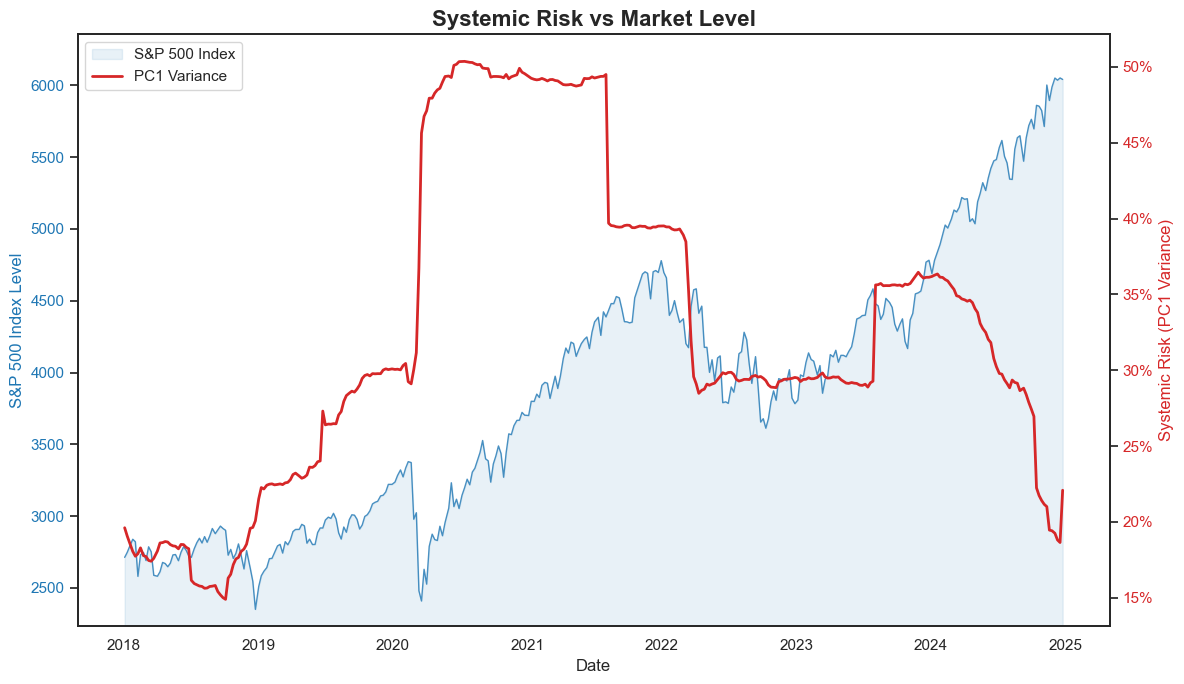

In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set(style="white", font='Arial')
plt.rcParams['axes.unicode_minus'] = False

def replicate_chapter_8_systemic_risk_zoomed(stock_file, index_file):
    print(f"--- 开始复现第8章：系统性风险 (优化纵坐标范围) ---")
    
    # ==========================================
    # 1. 数据准备
    # ==========================================
    try:
        sp500 = pd.read_csv(index_file)
        if sp500['Price'].dtype == 'object':
            sp500['Price'] = sp500['Price'].str.replace(',', '').astype(float)
        sp500['Date'] = pd.to_datetime(sp500['Date'])
        sp500 = sp500.sort_values('Date').set_index('Date')
    except Exception as e:
        print(f"指数文件读取失败: {e}")
        return

    try:
        df = pd.read_csv(stock_file, low_memory=False)
        date_col = next((c for c in ['DlyCalDt', 'date', 'Date'] if c in df.columns), None)
        price_col = next((c for c in ['DlyClose', 'Prc', 'Close', 'Est_Close'] if c in df.columns), None)
        
        if not price_col and 'DlyHigh' in df.columns:
            df['Est_Close'] = (df['DlyHigh'] + df['DlyLow']) / 2
            price_col = 'Est_Close'
            
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.sort_values([date_col, 'PERMNO'])
        df['Ret'] = df.groupby('PERMNO')[price_col].pct_change()
        
        mask = (df[date_col] >= '2016-01-01') & (df[date_col] <= '2024-12-31')
        returns_matrix = df.loc[mask].pivot(index=date_col, columns='PERMNO', values='Ret')
        
    except Exception as e:
        print(f"成分股文件读取失败: {e}")
        return

    # ==========================================
    # 2. 滚动计算 PC1
    # ==========================================
    window_size = 504
    step = 5
    
    common_idx = returns_matrix.index.intersection(sp500.index)
    returns_matrix = returns_matrix.loc[common_idx]
    sp500 = sp500.loc[common_idx]
    
    dates = []
    pc1_variance = []
    
    print(f"计算中 (窗口={window_size})...")
    
    for t in range(window_size, len(common_idx), step):
        window_data = returns_matrix.iloc[t-window_size : t]
        valid = window_data.columns[window_data.count() > 0.9 * window_size]
        if len(valid) < 50: continue
            
        X = window_data[valid].fillna(0)
        pca = PCA(n_components=1)
        pca.fit(X)
        
        dates.append(common_idx[t])
        pc1_variance.append(pca.explained_variance_ratio_[0])

    # ==========================================
    # 3. 绘图 (修改了纵坐标逻辑)
    # ==========================================
    results_df = pd.DataFrame({'Systemic_Risk': pc1_variance}, index=dates)
    plot_sp500 = sp500.loc[results_df.index]
    
    fig, ax1 = plt.subplots(figsize=(12, 7))
    
    # --- 左轴：S&P 500 指数 ---
    color = 'tab:blue'
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('S&P 500 Index Level', color=color, fontsize=12)
    
    # 【关键修改 1】计算价格区间，留出 5% 的上下边距
    y_min = plot_sp500['Price'].min() * 0.95
    y_max = plot_sp500['Price'].max() * 1.05
    
    # 【关键修改 2】设置 Y 轴范围，强制不从 0 开始
    ax1.set_ylim(y_min, y_max)
    
    # 【关键修改 3】fill_between 的下界设为 y_min (而不是默认的 0)
    ax1.fill_between(plot_sp500.index, plot_sp500['Price'], y_min, color=color, alpha=0.1, label='S&P 500 Index')
    ax1.plot(plot_sp500.index, plot_sp500['Price'], color=color, alpha=0.8, linewidth=1)
    
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(False)
    
    # --- 右轴：系统性风险 ---
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Systemic Risk (PC1 Variance)', color=color, fontsize=12)
    ax2.plot(results_df.index, results_df['Systemic_Risk'], color=color, linewidth=2, label='PC1 Variance')
    ax2.tick_params(axis='y', labelcolor=color)
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    
    plt.title('Systemic Risk vs Market Level', fontsize=16, fontweight='bold')
    
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.tight_layout()
    plt.show()

# --- 运行代码 ---
replicate_chapter_8_systemic_risk_zoomed('constituents.csv', 'sp500.csv')

--- 开始复现第8章：系统性风险 vs 指数累计收益 (Systemic Risk vs Cumulative Return) ---


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/1099760509.py:45: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Ret'] = df.groupby('PERMNO')[price_col].pct_change()


开始计算系统性风险指标 (窗口=504, 步长=5)...


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/1099760509.py:127: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


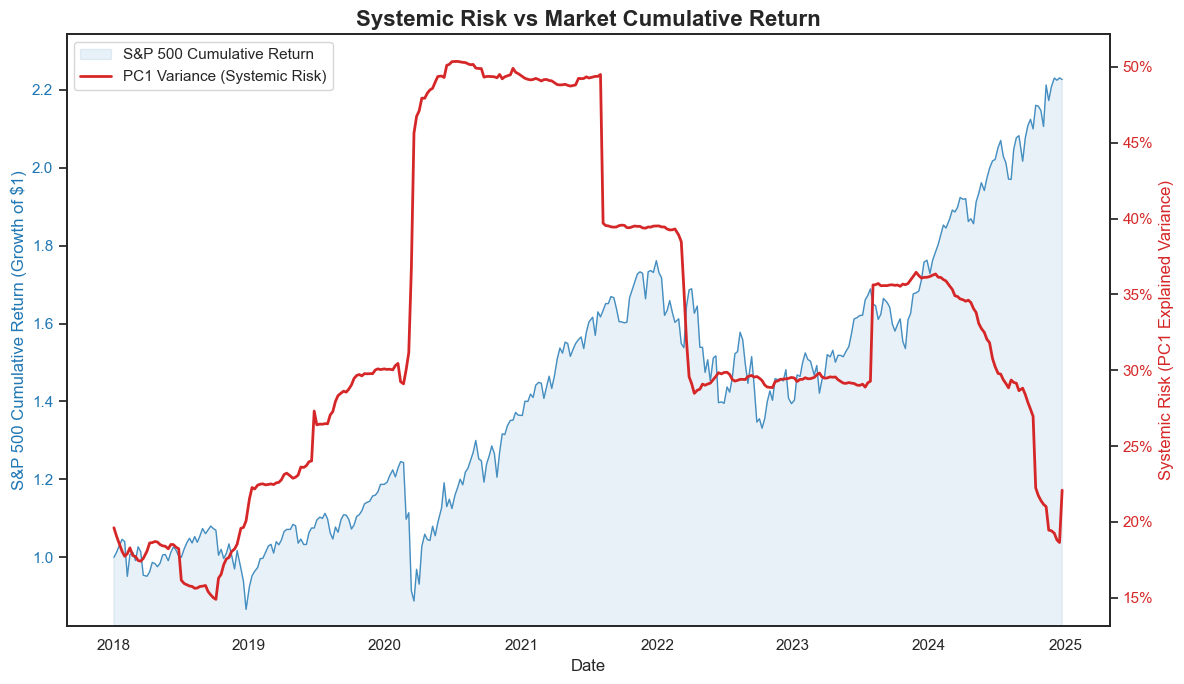

图表已生成：左轴为 S&P 500 累计收益 (Growth of $1)，右轴为系统性风险。


In [15]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set(style="white", font='Arial')
plt.rcParams['axes.unicode_minus'] = False

def replicate_chapter_8_with_returns(stock_file, index_file):
    print(f"--- 开始复现第8章：系统性风险 vs 指数累计收益 (Systemic Risk vs Cumulative Return) ---")
    
    # ==========================================
    # 1. 数据准备
    # ==========================================
    # 读取指数
    try:
        sp500 = pd.read_csv(index_file)
        if sp500['Price'].dtype == 'object':
            sp500['Price'] = sp500['Price'].str.replace(',', '').astype(float)
        sp500['Date'] = pd.to_datetime(sp500['Date'])
        sp500 = sp500.sort_values('Date').set_index('Date')
        
        # 计算指数累计收益 (Cumulative Return)
        sp500['Ret'] = sp500['Price'].pct_change()
        sp500['Cum_Ret'] = (1 + sp500['Ret']).cumprod()
        
    except Exception as e:
        print(f"指数文件读取失败: {e}")
        return

    # 读取成分股
    try:
        df = pd.read_csv(stock_file, low_memory=False)
        date_col = next((c for c in ['DlyCalDt', 'date', 'Date'] if c in df.columns), None)
        price_col = next((c for c in ['DlyClose', 'Prc', 'Close', 'Est_Close'] if c in df.columns), None)
        
        if not price_col and 'DlyHigh' in df.columns:
            df['Est_Close'] = (df['DlyHigh'] + df['DlyLow']) / 2
            price_col = 'Est_Close'
            
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.sort_values([date_col, 'PERMNO'])
        df['Ret'] = df.groupby('PERMNO')[price_col].pct_change()
        
        mask = (df[date_col] >= '2016-01-01') & (df[date_col] <= '2024-12-31')
        returns_matrix = df.loc[mask].pivot(index=date_col, columns='PERMNO', values='Ret')
        
    except Exception as e:
        print(f"成分股文件读取失败: {e}")
        return

    # ==========================================
    # 2. 滚动计算 PC1 解释方差
    # ==========================================
    window_size = 504  # 2年窗口
    step = 5           # 步长5天
    
    # 对齐数据
    common_idx = returns_matrix.index.intersection(sp500.index)
    returns_matrix = returns_matrix.loc[common_idx]
    sp500 = sp500.loc[common_idx]
    
    dates = []
    pc1_variance = []
    
    print(f"开始计算系统性风险指标 (窗口={window_size}, 步长={step})...")
    
    for t in range(window_size, len(common_idx), step):
        # 窗口切片
        window_data = returns_matrix.iloc[t-window_size : t]
        
        # 筛选有效股票
        valid = window_data.columns[window_data.count() > 0.9 * window_size]
        if len(valid) < 50: continue
            
        X = window_data[valid].fillna(0)
        
        # PCA
        pca = PCA(n_components=1)
        pca.fit(X)
        
        # 记录结果
        dates.append(common_idx[t])
        pc1_variance.append(pca.explained_variance_ratio_[0])

    # ==========================================
    # 3. 绘图：系统性风险 vs 指数累计收益
    # ==========================================
    results_df = pd.DataFrame({'Systemic_Risk': pc1_variance}, index=dates)
    
    # 对齐绘图用的指数数据 (累计收益)
    plot_sp500 = sp500.loc[results_df.index]
    
    # 归一化累计收益，使其从 1 开始 (或 100)
    # 简单处理：除以序列的第一个值
    plot_sp500['Cum_Ret_Rebased'] = plot_sp500['Cum_Ret'] / plot_sp500['Cum_Ret'].iloc[0]
    
    fig, ax1 = plt.subplots(figsize=(12, 7))
    
    # 左轴：S&P 500 累计收益 (蓝色填充区域)
    color = 'tab:blue'
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('S&P 500 Cumulative Return (Growth of $1)', color=color, fontsize=12)
    # 【关键修改 1】计算价格区间，留出 5% 的上下边距
    y_min = plot_sp500['Cum_Ret_Rebased'].min() * 0.95
    y_max = plot_sp500['Cum_Ret_Rebased'].max() * 1.05
    
    # 【关键修改 2】设置 Y 轴范围，强制不从 0 开始
    ax1.set_ylim(y_min, y_max)
    
    ax1.fill_between(plot_sp500.index, plot_sp500['Cum_Ret_Rebased'], color=color, alpha=0.1, label='S&P 500 Cumulative Return')
    ax1.plot(plot_sp500.index, plot_sp500['Cum_Ret_Rebased'], color=color, alpha=0.8, linewidth=1)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(False) 
    
    # 右轴：系统性风险 (红色曲线)
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Systemic Risk (PC1 Explained Variance)', color=color, fontsize=12)
    ax2.plot(results_df.index, results_df['Systemic_Risk'], color=color, linewidth=2, label='PC1 Variance (Systemic Risk)')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # 格式化右轴为百分比
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    
    plt.title('Systemic Risk vs Market Cumulative Return', fontsize=16, fontweight='bold')
    
    # 添加图例说明
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.tight_layout()
    plt.savefig('Systemic_Risk_vs_Return.png')
    plt.show()
    
    print("图表已生成：左轴为 S&P 500 累计收益 (Growth of $1)，右轴为系统性风险。")

# --- 运行代码 ---
# 请确保您的 CSV 文件名正确
replicate_chapter_8_with_returns('constituents.csv', 'sp500.csv')

--- 开始因子归因分析 (Factor Correlation Analysis) ---
1. 正在重新计算主成分组合 (PPs) 收益率...


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/3501057403.py:30: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Ret'] = df.groupby('PERMNO')[price_col].pct_change()


   PPs 收益率计算完成。
2. 正在下载 Fama-French 因子数据 (这可能需要几秒钟)...


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/3501057403.py:89: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start=start_date, end=end_date)[0]
/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_9128/3501057403.py:92: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start=start_date, end=end_date)[0]


   因子数据下载成功。


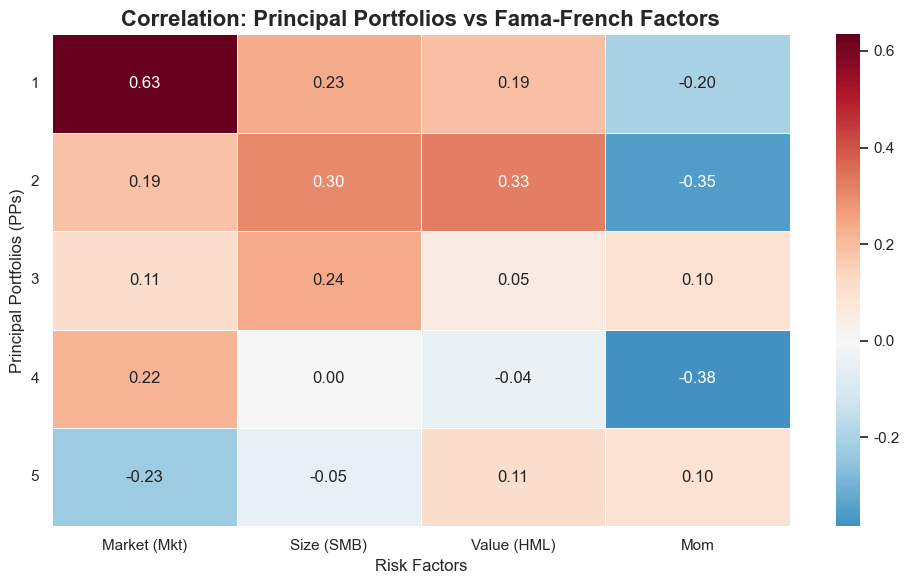

------------------------------
分析解读指南:
1. PP1 vs Market: 相关性应该非常高 (>0.9)，验证了 PP1 代表市场风险。
2. PP2/PP3: 观察颜色深浅。
   - 如果 PP2 与 HML 正相关(红色)，说明 PP2 捕捉了'价值股'风格。
   - 如果 PP2 与 HML 负相关(蓝色)，说明 PP2 捕捉了'成长股'风格。
   - 如果 PP2 与 Mom 正相关，说明 PP2 捕捉了'动量'效应。
------------------------------


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas_datareader.data as web # 需要安装 pandas-datareader

# 设置绘图风格
sns.set(style="white", font='Arial')
plt.rcParams['axes.unicode_minus'] = False

def analyze_factor_correlation(stock_file):
    print("--- 开始因子归因分析 (Factor Correlation Analysis) ---")
    
    # ==========================================
    # 1. 重新构建 PP1 - PP5 (为了获取它们的收益率序列)
    # ==========================================
    print("1. 正在重新计算主成分组合 (PPs) 收益率...")
    try:
        df = pd.read_csv(stock_file, low_memory=False)
        # 识别列
        date_col = next((c for c in ['DlyCalDt', 'date', 'Date'] if c in df.columns), None)
        price_col = next((c for c in ['DlyClose', 'Prc', 'Close', 'Est_Close'] if c in df.columns), None)
        if not price_col and 'DlyHigh' in df.columns:
            df['Est_Close'] = (df['DlyHigh'] + df['DlyLow']) / 2
            price_col = 'Est_Close'
            
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.sort_values([date_col, 'PERMNO'])
        df['Ret'] = df.groupby('PERMNO')[price_col].pct_change()
        
        mask = (df[date_col] >= '2016-01-01') & (df[date_col] <= '2024-12-31')
        returns_matrix = df.loc[mask].pivot(index=date_col, columns='PERMNO', values='Ret')
        
    except Exception as e:
        print(f"读取股票数据失败: {e}")
        return

    # 滚动计算 PPs
    window_size = 504
    n_pps = 5
    rf_rate = 0.02 / 252
    
    pp_returns = {i: [] for i in range(1, n_pps + 1)}
    dates = []
    
    # 为了速度，step设为5 (周频采样)，若需高精度请设为1
    step = 5
    trading_days = returns_matrix.index
    
    for t in range(window_size, len(trading_days) - 1, step):
        window_data = returns_matrix.iloc[t-window_size : t]
        valid = window_data.columns[window_data.count() > 0.9 * window_size]
        if len(valid) < 50: continue
            
        X = window_data[valid].fillna(0)
        pca = PCA(n_components=n_pps)
        pca.fit(X)
        next_ret = returns_matrix[valid].iloc[t].fillna(0)
        dates.append(trading_days[t])
        
        for i in range(n_pps):
            w = pca.components_[i]
            if i == 0 and np.sum(w) < 0: w = -w # PP1 市场方向校正
            
            pos, neg = w > 0, w < 0
            sum_p, sum_n = np.sum(w[pos]), np.sum(np.abs(w[neg]))
            
            fw = np.zeros_like(w)
            if sum_p > 0: fw[pos] = w[pos] / sum_p
            if sum_n > 0: fw[neg] = w[neg] / sum_n
            
            r = np.sum(fw * next_ret)
            if sum_n > 0: r += rf_rate
            pp_returns[i + 1].append(r)
            
    pp_df = pd.DataFrame(pp_returns, index=dates)
    print("   PPs 收益率计算完成。")

    # ==========================================
    # 2. 获取 Fama-French 因子数据
    # ==========================================
    print("2. 正在下载 Fama-French 因子数据 (这可能需要几秒钟)...")
    start_date = pp_df.index.min()
    end_date = pp_df.index.max()
    
    try:
        # 下载 Fama-French 3 Factors (Daily)
        ff3 = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start=start_date, end=end_date)[0]
        
        # 下载 Momentum Factor (Daily)
        mom = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start=start_date, end=end_date)[0]
        
        # 合并因子
        factors = pd.merge(ff3, mom, left_index=True, right_index=True)
        
        # FF 数据通常是百分比 (e.g., 1.5 代表 1.5%)，需要除以 100
        factors = factors / 100.0
        
        # 重命名以便理解
        factors.rename(columns={
            'Mkt-RF': 'Market (Mkt)',
            'SMB': 'Size (SMB)',
            'HML': 'Value (HML)',
            'Mom   ': 'Momentum (Mom)' # 有时列名带空格
        }, inplace=True)
        
        # 清理列名空格
        factors.columns = factors.columns.str.strip()
        
        print("   因子数据下载成功。")
        
    except Exception as e:
        print(f"错误: 无法下载 Fama-French 数据。请检查网络或 pandas-datareader 安装。\n详细信息: {e}")
        return

    # ==========================================
    # 3. 对齐数据与计算相关性
    # ==========================================
    # 取交集日期
    common_idx = pp_df.index.intersection(factors.index)
    combined_df = pd.concat([pp_df.loc[common_idx], factors.loc[common_idx]], axis=1)
    
    # 计算相关性矩阵
    corr_matrix = combined_df.corr()
    
    # 我们只关心 PPs (行) 与 Factors (列) 的关系
    pp_cols = [1, 2, 3, 4, 5]
    factor_cols = ['Market (Mkt)', 'Size (SMB)', 'Value (HML)', 'Mom']
    
    # 筛选子矩阵
    # 注意：检查 factors 实际列名
    available_factors = [c for c in factor_cols if c in corr_matrix.columns]
    target_corr = corr_matrix.loc[pp_cols, available_factors]
    
    # ==========================================
    # 4. 绘制热力图 (Heatmap)
    # ==========================================
    plt.figure(figsize=(10, 6))
    sns.heatmap(target_corr, annot=True, cmap='RdBu_r', center=0, fmt='.2f', 
                linewidths=0.5, annot_kws={"size": 12})
    
    plt.title('Correlation: Principal Portfolios vs Fama-French Factors', fontsize=16, fontweight='bold')
    plt.ylabel('Principal Portfolios (PPs)', fontsize=12)
    plt.xlabel('Risk Factors', fontsize=12)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('PP_Factor_Correlation.png')
    plt.show()
    
    print("-" * 30)
    print("分析解读指南:")
    print("1. PP1 vs Market: 相关性应该非常高 (>0.9)，验证了 PP1 代表市场风险。")
    print("2. PP2/PP3: 观察颜色深浅。")
    print("   - 如果 PP2 与 HML 正相关(红色)，说明 PP2 捕捉了'价值股'风格。")
    print("   - 如果 PP2 与 HML 负相关(蓝色)，说明 PP2 捕捉了'成长股'风格。")
    print("   - 如果 PP2 与 Mom 正相关，说明 PP2 捕捉了'动量'效应。")
    print("-" * 30)

# --- 运行代码 ---
analyze_factor_correlation('constituents.csv')

--- Starting Rolling PCA Selection (Dynamic Jolliffe Method) ---


/var/folders/r3/4trw45fn1h914_7snn00ypph0000gn/T/ipykernel_11355/4215397823.py:37: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Ret'] = df.groupby('PERMNO')[price_col].pct_change()


Data Matrix Shape: (2264, 710)

--- Backtest Settings ---
Lookback Window: 504 days
Rebalance Freq:  Every 21 days
Eigenvalue Threshold: 0.7
Selection Logic: Dynamic (1 stock per significant PC)
------------------------------------------------------------
Rebalance Date: 2018-01-03
Significant PCs (Eig > 0.7): 137
Selected Stocks Count: 96
------------------------------------------------------------
Rebalance Date: 2018-04-05
Significant PCs (Eig > 0.7): 139
Selected Stocks Count: 98
------------------------------------------------------------
Rebalance Date: 2018-07-05
Significant PCs (Eig > 0.7): 143
Selected Stocks Count: 103
------------------------------------------------------------
Rebalance Date: 2018-10-03
Significant PCs (Eig > 0.7): 143
Selected Stocks Count: 112
------------------------------------------------------------
Rebalance Date: 2019-01-04
Significant PCs (Eig > 0.7): 135
Selected Stocks Count: 108
------------------------------------------------------------
Rebala

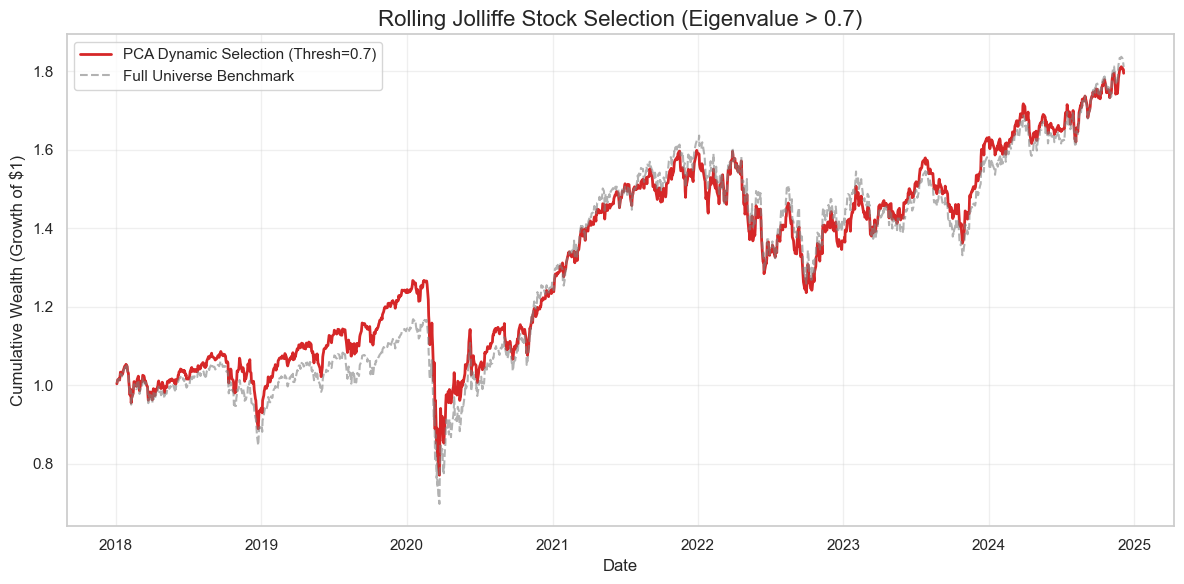


Performance Summary
Total Return:
  - PCA Portfolio: 79.54%
  - Benchmark:     81.15%

Annualized Volatility:
  - PCA Portfolio: 19.15%
  - Benchmark:     20.85%

Correlation with Benchmark: 0.9733

Tracking Error: 0.0267


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 设置绘图风格
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

def rolling_jolliffe_selection(file_path):
    print(f"--- Starting Rolling PCA Selection (Dynamic Jolliffe Method) ---")
    
    # ==========================================
    # 1. 数据读取与预处理 (Data Preprocessing)
    # ==========================================
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except FileNotFoundError:
        print("Error: File not found.")
        return

    # 识别列
    date_col = next((c for c in ['DlyCalDt', 'date', 'Date'] if c in df.columns), None)
    price_col = next((c for c in ['DlyClose', 'Prc', 'Close', 'Est_Close'] if c in df.columns), None)
    if not price_col and 'DlyHigh' in df.columns:
        df['Est_Close'] = (df['DlyHigh'] + df['DlyLow']) / 2
        price_col = 'Est_Close'
        
    # 转换格式
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.sort_values([date_col, 'PERMNO'])
    
    # 计算日收益率
    df['Ret'] = df.groupby('PERMNO')[price_col].pct_change()
    
    # 筛选时间 (2016-2024)
    mask = (df[date_col] >= '2016-01-01') & (df[date_col] <= '2024-12-31')
    
    # 构建收益率矩阵 (日期 x 股票)
    returns_matrix = df.loc[mask].pivot(index=date_col, columns='PERMNO', values='Ret')
    
    print(f"Data Matrix Shape: {returns_matrix.shape}")

    # ==========================================
    # 2. 策略参数设置 (Strategy Parameters)
    # ==========================================
    LOOKBACK_WINDOW = 504      # 回看窗口：2年 (更长的窗口PCA更稳定)
    REBALANCE_FREQ = 21        # 调仓频率：1个月
    EIGEN_THRESHOLD = 0.7      # 特征值阈值 (Jolliffe 建议 0.7, Kaiser 建议 1.0)
                               # 逻辑：只通过那些"解释力强"的主成分来选股

    strategy_returns = []
    benchmark_returns = [] 
    dates = []
    
    trading_days = returns_matrix.index
    
    print(f"\n--- Backtest Settings ---")
    print(f"Lookback Window: {LOOKBACK_WINDOW} days")
    print(f"Rebalance Freq:  Every {REBALANCE_FREQ} days")
    print(f"Eigenvalue Threshold: {EIGEN_THRESHOLD}")
    print(f"Selection Logic: Dynamic (1 stock per significant PC)")
    
    # ==========================================
    # 3. 滚动循环 (Rolling Loop)
    # ==========================================
    for t in range(LOOKBACK_WINDOW, len(trading_days) - REBALANCE_FREQ, REBALANCE_FREQ):
        
        # A. 获取训练数据
        train_data = returns_matrix.iloc[t-LOOKBACK_WINDOW : t]
        
        # B. 动态剔除缺失值 (只保留数据覆盖率 > 80% 的股票)
        valid_stocks = train_data.columns[train_data.count() > 0.8 * LOOKBACK_WINDOW]
        
        # 保护机制：如果有效股票太少，无法进行PCA
        if len(valid_stocks) < 10:
            continue 
            
        # 填充缺失值
        X_train = train_data[valid_stocks].fillna(0)
        
        # C. 标准化 (PCA 基于相关系数矩阵)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train)
        
        # D. 运行 PCA
        # 不限制组件数量，计算所有
        pca = PCA()
        pca.fit(X_scaled)
        
        # E. 动态选股逻辑 (Dynamic Selection)
        # 1. 获取特征值
        eigenvalues = pca.explained_variance_
        
        # 2. 确定显著主成分 (Significant PCs)
        # 找出特征值 > 阈值的主成分索引
        significant_pc_indices = np.where(eigenvalues > EIGEN_THRESHOLD)[0]
        
        # 3. 为每个显著主成分选一只代表性股票
        loadings = pca.components_
        selected_indices = set() # 使用集合去重 (虽然很少见，但可能一只股票同时主导两个PC)

        for idx in significant_pc_indices:
            # 找到当前主成分中，载荷(绝对值)最大的股票索引
            # np.argmax 返回最大值的索引
            stock_idx = np.argmax(np.abs(loadings[idx]))
            selected_indices.add(stock_idx)
            
        # 转换为股票代码
        selected_tickers = valid_stocks[list(selected_indices)]
        
        # F. 样本外回测 (Out-of-sample Testing)
        hold_start = t
        hold_end = t + REBALANCE_FREQ
        
        # 获取选中股票在持有期的收益
        future_returns_subset = returns_matrix[selected_tickers].iloc[hold_start : hold_end]
        future_returns_all = returns_matrix.iloc[hold_start : hold_end]
        
        # 计算等权重组合收益
        period_strat_ret = future_returns_subset.mean(axis=1).fillna(0)
        period_bench_ret = future_returns_all.mean(axis=1).fillna(0)
        
        strategy_returns.extend(period_strat_ret)
        benchmark_returns.extend(period_bench_ret)
        dates.extend(period_strat_ret.index)
        
        # G. 打印英文日志与股票列表 (只打印每年的第一次调仓，避免刷屏，或者每季度)
        if t % (REBALANCE_FREQ * 3) == 0: 
            current_date = trading_days[t].date()
            print("-" * 60)
            print(f"Rebalance Date: {current_date}")
            print(f"Significant PCs (Eig > {EIGEN_THRESHOLD}): {len(significant_pc_indices)}")
            print(f"Selected Stocks Count: {len(selected_tickers)}")
            # print(f"Selected Tickers List: {selected_tickers.tolist()}")

    # ==========================================
    # 4. 结果分析与绘图 (Analysis & Plotting)
    # ==========================================
    res_df = pd.DataFrame({
        'Dynamic_Portfolio': strategy_returns,
        'Benchmark': benchmark_returns
    }, index=dates)
    
    # 计算累计净值
    cum_nav = (1 + res_df).cumprod()
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(cum_nav.index, cum_nav['Dynamic_Portfolio'], 
             label=f'PCA Dynamic Selection (Thresh={EIGEN_THRESHOLD})', color='#d62728', linewidth=2)
    
    plt.plot(cum_nav.index, cum_nav['Benchmark'], 
             label='Full Universe Benchmark', color='grey', alpha=0.6, linestyle='--')
    
    plt.title(f'Rolling Jolliffe Stock Selection (Eigenvalue > {EIGEN_THRESHOLD})', fontsize=16)
    plt.ylabel('Cumulative Wealth (Growth of $1)', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('Rolling_Jolliffe_Selection.png')
    plt.show()
    
    # 统计指标
    total_ret = cum_nav.iloc[-1] - 1
    vol = res_df.std() * np.sqrt(252)
    corr = res_df['Dynamic_Portfolio'].corr(res_df['Benchmark'])

    print("\n" + "="*40)
    print("Performance Summary")
    print("="*40)
    print(f"Total Return:")
    print(f"  - PCA Portfolio: {total_ret['Dynamic_Portfolio']:.2%}")
    print(f"  - Benchmark:     {total_ret['Benchmark']:.2%}")
    print(f"\nAnnualized Volatility:")
    print(f"  - PCA Portfolio: {vol['Dynamic_Portfolio']:.2%}")
    print(f"  - Benchmark:     {vol['Benchmark']:.2%}")
    print(f"\nCorrelation with Benchmark: {corr:.4f}")
    print(f"\nTracking Error: {1-corr:.4f}")
    print("="*40)

# --- 运行 ---
rolling_jolliffe_selection('constituents.csv')

In [1]:
import pandas as pd

# 读取数据文件
file_path = 'S&P 500 Historical Components & Changes(11-16-2025).csv'
df = pd.read_csv(file_path)

# 将日期列转换为 datetime 格式并按时间排序
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# 定义辅助函数：处理 tickers 字符串，将其转换为集合
def parse_tickers(ticker_str):
    if pd.isna(ticker_str):
        return set()
    return set(ticker_str.split(','))

# 应用函数，将每行的 tickers 转换为集合
df['ticker_set'] = df['tickers'].apply(parse_tickers)

# 初始化列表，用于存储剔除记录
removals = []

# 遍历数据，比较每一天与前一天的成分股差异
# 从索引 1 开始，与索引 i-1 比较
for i in range(1, len(df)):
    current_date = df.iloc[i]['date']
    current_tickers = df.iloc[i]['ticker_set']
    prev_tickers = df.iloc[i-1]['ticker_set']
    
    # 找出在前一天存在但当天不存在的 ticker (被剔除的股票)
    removed_tickers = prev_tickers - current_tickers
    
    # 将每个剔除事件添加到列表中
    for ticker in removed_tickers:
        removals.append({
            'Year': current_date.year,
            'Ticker': ticker
        })

# 将列表转换为 DataFrame
removals_df = pd.DataFrame(removals)

# 筛选 2016 年至 2024 年的数据
target_years = list(range(2016, 2025))
filtered_removals = removals_df[removals_df['Year'].isin(target_years)]

# 按年份统计剔除数量，并确保所有年份都显示（即使数量为0）
annual_counts = filtered_removals.groupby('Year')['Ticker'].count().reindex(target_years, fill_value=0).reset_index(name='Count')

# 计算 2016-2024 年的平均剔除数量
average_removals = annual_counts['Count'].mean()

# 输出英文结果表格
print("S&P 500 Removals by Year (2016-2024):")
print(annual_counts.to_string(index=False))
print(f"\nAverage Annual Removals: {average_removals:.2f}")

# 将结果保存为 CSV 文件
csv_filename = 'sp500_removals_2016_2024.csv'
annual_counts.to_csv(csv_filename, index=False)
print(f"\nTable saved to {csv_filename}")

S&P 500 Removals by Year (2016-2024):
 Year  Count
 2016     27
 2017     28
 2018     24
 2019     29
 2020     20
 2021     21
 2022     24
 2023     19
 2024     20

Average Annual Removals: 23.56

Table saved to sp500_removals_2016_2024.csv
